In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import torch
from cot.data import BinaryCopy, Parity, MixedDataset
from cot.config import CHECK_DIR
from cot.models import TransformerConfig, Transformer

In [3]:
problem = "parity"
n_data_per_len = 2048
n_len=32
emb_dim=128
pos_dim = 32
freeze_pos = True
n_head=1
n_layer=2
n_epochs = 100
batch_size = 256

In [4]:
subprocess.run(["python", "-m", "../src/cot/data/data_processing.py", 
                "--n_len", str(n_len),
                "--n_data_per_len", str(n_data_per_len),
                "--problem", problem
                ])

/private/home/vivc/miniconda/envs/llm/bin/python: Relative module names not supported


CompletedProcess(args=['python', '-m', '../src/cot/data/data_processing.py', '--n_len', '32', '--n_data_per_len', '2048', '--problem', 'parity'], returncode=1)

In [5]:
subprocess.run(["python", "../src/cot/train.py", 
                "--n_head", str(n_head),
                "--n_layer", str(n_layer),
                "--n_epochs", str(n_epochs),
                "--n_len", str(n_len), 
                "--batch_size", str(batch_size), 
                "--emb_dim", str(emb_dim),
                "--pos_dim", str(pos_dim),
                "--freeze_pos", str(freeze_pos), 
                "--load_checkpoint", str(True),
                "--problem", problem,
                ])

05-17 08:38:00 INFO [data_processing.py:127] Loading data from /checkpoint/vivc/data/parity.
05-17 08:38:00 INFO [data_processing.py:127] Loading data from /checkpoint/vivc/data/parity.
05-17 08:38:00 INFO [train.py:146] Problem: parity. Number of training data: 23551.
05-17 08:38:02 INFO [train.py:175] Device used: cuda:0.
05-17 08:38:02 INFO [train.py:181] Loading from checkpoint /checkpoint/vivc/models/parity/model.pth.
05-17 08:38:02 ERROR [train.py:187] Model has been trained for 500 epochs, which is higher than 100


CompletedProcess(args=['python', '../src/cot/train.py', '--n_head', '1', '--n_layer', '2', '--n_epochs', '100', '--n_len', '32', '--batch_size', '256', '--emb_dim', '128', '--pos_dim', '32', '--freeze_pos', 'True', '--load_checkpoint', 'True', '--problem', 'parity'], returncode=0)

## Looking at the evaluation metrics

In [6]:
path = CHECK_DIR / problem.replace('-', '_') / 'model.pth'

checkpoint = torch.load(path)

timestamps = checkpoint['timestamps']
ind = timestamps != -1
timestamps = timestamps[ind]

evals = checkpoint['evals'][ind]
eval_dim = evals.shape[1] // 2

meaning = checkpoint['meaning']
assert len(meaning) == eval_dim

In [7]:
path

PosixPath('/checkpoint/vivc/models/parity/model.pth')

In [8]:
acc_by_len = evals[:, :n_len]
test_acc_by_len = evals[:, eval_dim:eval_dim + n_len]
spe_acc = evals[:, n_len:n_len + 3]
test_spe_acc = evals[:, eval_dim + n_len:eval_dim + n_len + 3]

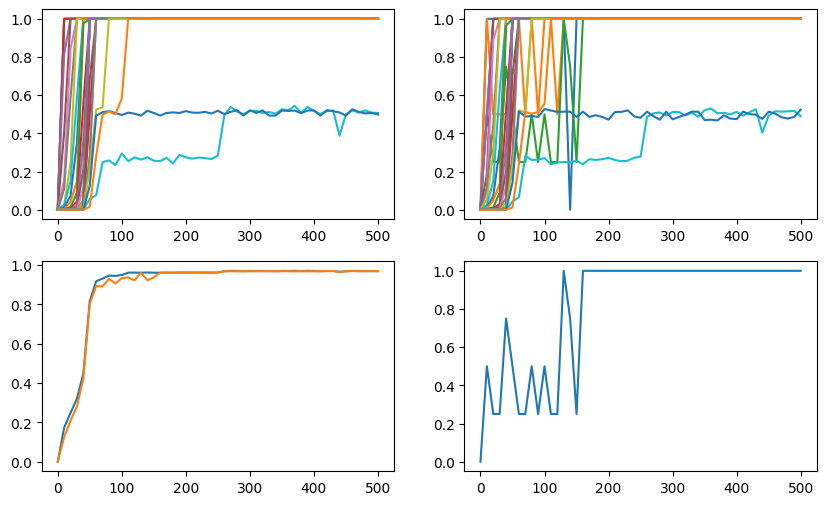

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes[0, 0].plot(timestamps, acc_by_len)
axes[0, 1].plot(timestamps, test_acc_by_len)
axes[1, 0].plot(timestamps, acc_by_len.mean(axis=1))
axes[1, 0].plot(timestamps, test_acc_by_len.mean(axis=1))
axes[1, 1].plot(timestamps, spe_acc[:, 2])
# axes[1, 1].plot(timestamps, test_spe_acc[:, 2])
# axes[1, 1].set_xlim(0, 50)

## Looking at the model

In [10]:
token_emb = checkpoint['model_state_dict']['embeddings.token_emb.weight'].cpu()
pos_emb = checkpoint['model_state_dict']['embeddings.pos_emb.weight'].cpu()

In [11]:
lengths = list(np.arange(n_len) + 1)

if problem == 'parity':
    testset = Parity()
elif problem == 'binary-copy':
    testset = BinaryCopy()
elif problem == 'no-cot':
    testset = Parity(cot=False)
elif problem == 'mix':
    testset = MixedDataset()
testset.set_data(lengths, data_type="test")

In [13]:
config = TransformerConfig(
    vocab_size=torch.max(testset.data).item() + 1,
    emb_dim=emb_dim,
    pos_emb=True,
    pos_dim=pos_dim,
    freeze_pos=freeze_pos,
    seq_len=len(testset[0]),
    emb_dropout=0,
    n_head=n_head,
    n_layer=n_layer,
)

model = Transformer(config)
model.load_state_dict(checkpoint["model_state_dict"])
# model.to(device=device)
model.eval()

Transformer(
  (embeddings): Embedding(
    (token_emb): Embedding(5, 128)
    (pos_emb): Embedding(67, 32)
  )
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv_mat): Linear(in_features=128, out_features=384, bias=False)
        (output): Linear(in_features=128, out_features=128, bias=False)
      )
      (norm_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ffn): FeedForward(
        (fc1): Linear(in_features=128, out_features=512, bias=False)
        (fc2): Linear(in_features=512, out_features=128, bias=False)
      )
    )
  )
  (output_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (output): Linear(in_features=128, out_features=5, bias=False)
)

In [22]:
model.blocks[1].ffn.parameters()

<generator object Module.parameters at 0x7f4d7c1bf680>

In [ ]:
sequence = testset.data
# sequence = sequence.to(device=device, dtype=torch.long)

with torch.no_grad():
    logits, attentions = model(sequence, verbose=True)

We can extract the attention scores that we would like to maximize.

In [ ]:
i = -1
attn00 = attentions[0, i, 0].cpu()
attn01 = attentions[0, i, 1].cpu()
attn10 = attentions[1, i, 0].cpu()
attn20 = attentions[2, i, 0].cpu()
attn11 = attentions[1, i, 1].cpu()
attn20 = attentions[2, i, 0].cpu()
attn21 = attentions[2, i, 1].cpu()

In [ ]:
attentions.shape

torch.Size([3, 24574, 2, 67, 67])

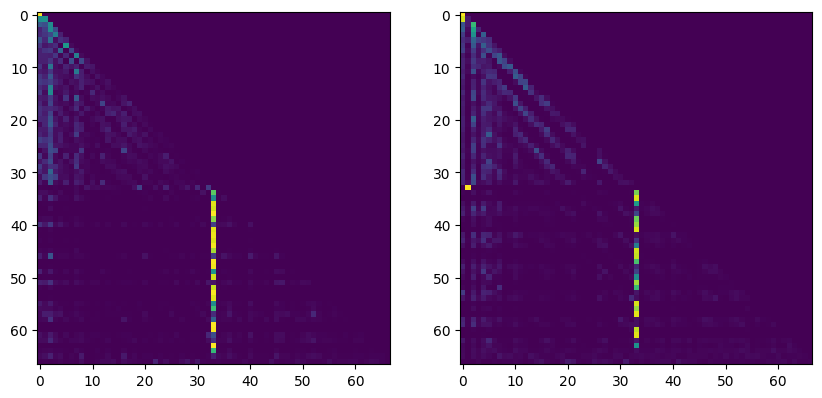

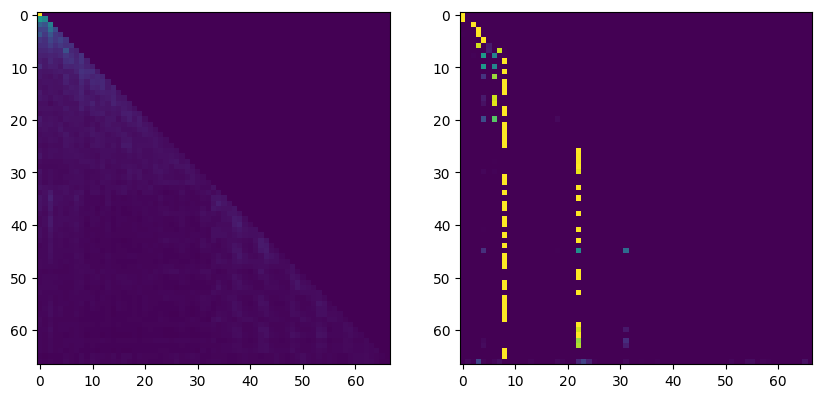

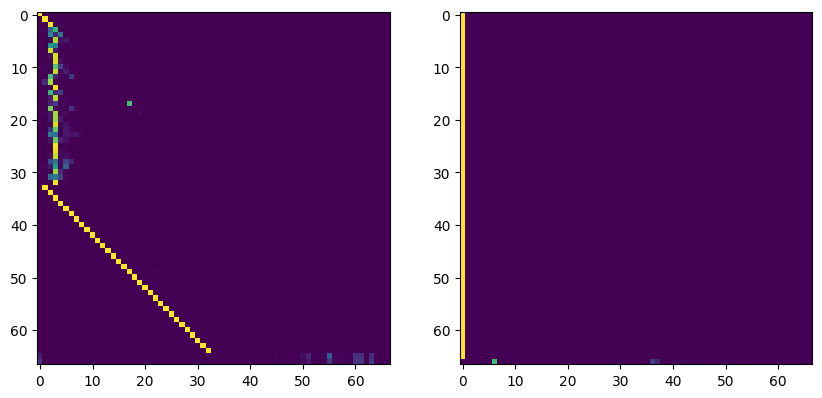

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(attn00)
axes[1].imshow(attn01)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(attn10)
axes[1].imshow(attn11)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(attn20)
axes[1].imshow(attn21)

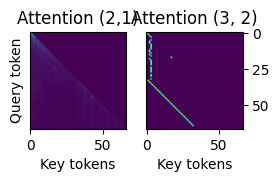

In [ ]:
WIDTH = 5.5
HEIGHT = WIDTH / 1.5
fig, axes = plt.subplots(1, 2, figsize=(.5 * WIDTH, .5 * HEIGHT))
axes[0].imshow(attn10)
axes[1].imshow(attn20 > .5)
axes[0].set_title('Attention (2,1)')
axes[1].set_title('Attention (3, 2)')
axes[0].set_xlabel('Key tokens')
axes[1].set_xlabel('Key tokens')
axes[0].set_ylabel('Query token')
axes[0].set_yticks([])
axes[1].yaxis.tick_right()
fig.savefig('attention_map_corrupted.pdf', bbox_inches="tight", dpi=300)

In [ ]:
sequence[i]

tensor([5, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 3],
       dtype=torch.int32)